In [153]:
import pandas as pd
import numpy as np
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak
import matplotlib.pyplot as plt
from scipy.signal import decimate
from IPython.display import Audio 
from scipy.stats import norm

from tslearn.piecewise import PiecewiseAggregateApproximation
#from tslearn.piecewise import SymbolicAggregateApproximation
from pyts.approximation import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from sklearn.preprocessing import StandardScaler

from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from scipy.spatial.distance import cdist
from fastdtw import fastdtw

In [154]:
%%time
X_test = np.load("RavdessTimeSeries_X_test.npy")
X_train = np.load("RavdessTimeSeries_X_train.npy")
Y_test = pd.read_csv("RavdessTimeSeries_Y_test.csv")
Y_train = pd.read_csv("RavdessTimeSeries_Y_train.csv")

X_test_trimm = np.load("RavdessTimeSeriesTrim_X_test.npy")
X_train_trimm = np.load("RavdessTimeSeriesTrim_X_train.npy")

print(Y_train.shape, Y_test.shape)
print(X_train.shape, X_test.shape)

MemoryError: Unable to allocate 4.14 GiB for an array with shape (556267712,) and data type float64

# Trimming & its effect

    some audio starts from different point...

In [3]:
#taking different audio (of different actors) with similar characteristics
mask = (Y_train['emotion']=='happy')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')
#& (Y_train['sex']=='M')

indices = Y_train.index[mask]
for i in indices:
    print("index:", i, "  actor:",  Y_train['actor'][i])

index: 12   actor: 1
index: 13   actor: 1
index: 116   actor: 2
index: 117   actor: 2
index: 220   actor: 3
index: 221   actor: 3
index: 324   actor: 4
index: 325   actor: 4
index: 428   actor: 5
index: 429   actor: 5
index: 532   actor: 6
index: 533   actor: 6
index: 636   actor: 7
index: 637   actor: 7
index: 740   actor: 8
index: 741   actor: 8
index: 844   actor: 9
index: 845   actor: 9
index: 948   actor: 10
index: 949   actor: 10
index: 1052   actor: 11
index: 1053   actor: 11
index: 1156   actor: 12
index: 1157   actor: 12
index: 1260   actor: 13
index: 1261   actor: 13
index: 1364   actor: 14
index: 1365   actor: 14
index: 1468   actor: 15
index: 1469   actor: 15
index: 1572   actor: 16
index: 1573   actor: 16
index: 1676   actor: 17
index: 1677   actor: 17
index: 1780   actor: 18
index: 1781   actor: 18


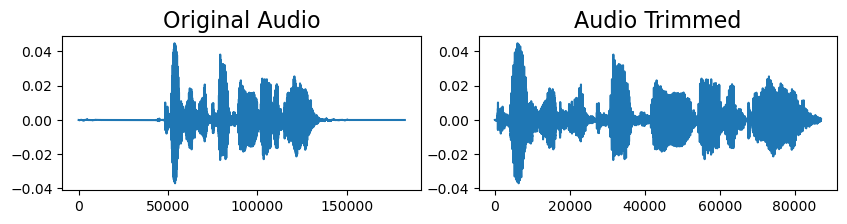

In [4]:
ts1 = X_train[24]
ts2 = X_train[212]
ts1_trimm = X_train_trimm[24]
ts2_trimm = X_train_trimm[212]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10, 2))

ax1.plot(ts1)
ax1.set_title('Original Audio', fontsize=16)


ax2.plot(ts1_trimm)
ax2.set_title('Audio Trimmed', fontsize=16)

fig.subplots_adjust(hspace=0.3, wspace=0.16)
plt.show()

     ...and this can influence the distance between two similar audio recordings. Show the difference between trimmed and     original distance measures (dtw)

In [5]:
%%time
%%capture --no-display

mask_happy = (Y_train['emotion']=='happy')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='strong')&(Y_train["vocal_channel"]=='song')
indices_happy = Y_train.index[mask_happy]

mask_sad = (Y_train['emotion']=='sad')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')
indices_sad = Y_train.index[mask_sad]

mask_fearful = (Y_train['emotion']=='fearful')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')
indices_fearful = Y_train.index[mask_fearful]

X_happy, X_happy_trimm = X_train[indices_happy], X_train_trimm[indices_happy]
X_sad, X_sad_trimm = X_train[indices_sad], X_train_trimm[indices_sad]
X_fearful, X_fearful_trimm = X_train[indices_fearful], X_train_trimm[indices_fearful]

#Scaling with MinMax
scaler = TimeSeriesScalerMinMax()

X_happy_ = X_happy.reshape(X_happy.shape[0], X_happy.shape[1], 1)
X_happy_trimm_ = X_happy_trimm.reshape(X_happy_trimm.shape[0], X_happy_trimm.shape[1], 1)
X_sad_ = X_sad.reshape(X_sad.shape[0], X_sad.shape[1], 1)
X_sad_trimm_ = X_sad_trimm.reshape(X_sad_trimm.shape[0], X_sad_trimm.shape[1], 1)
X_fearful_ = X_fearful.reshape(X_fearful.shape[0], X_fearful.shape[1], 1)
X_fearful_trimm_ = X_fearful_trimm.reshape(X_fearful_trimm.shape[0], X_fearful_trimm.shape[1], 1)


X_happy_scaled = scaler.fit_transform(X_happy_)
X_happy_trimm_scaled = scaler.fit_transform(X_happy_trimm_)
X_sad_scaled = scaler.fit_transform(X_sad_)
X_sad_trimm_scaled = scaler.fit_transform(X_sad_trimm_)
X_fearful_scaled = scaler.fit_transform(X_fearful_)
X_fearful_trimm_scaled = scaler.fit_transform(X_fearful_trimm_)


CPU times: total: 4min 10s
Wall time: 4min 10s


In [123]:
np.random.seed(42)
# Generate 200 different pairs of numbers in the range [0-17]
pairs = np.random.randint(0, 17, size=(200, 2))

In [96]:
%%time
%%capture --no-display

n_paa_segments = 1000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
dist_similar_audio = []
dist_similar_audio_trimm = []

for pair in pairs:
    ts1 = X_fearful_scaled[pair[0]]
    ts2 = X_fearful_scaled[pair[1]]
    ts1_paa = paa.fit_transform(ts1.reshape(1, -1))
    ts2_paa = paa.fit_transform(ts2.reshape(1, -1))
    dist, _ = fastdtw(ts1_paa, ts2_paa, radius=n_paa_segments)
    dist_similar_audio.append(dist)
    
    ts1_trimm = X_fearful_trimm_scaled[pair[0]]
    ts2_trimm = X_fearful_trimm_scaled[pair[1]]
    ts1_trimm_paa = paa.fit_transform(ts1_trimm.reshape(1, -1))
    ts2_trimm_paa = paa.fit_transform(ts2_trimm.reshape(1, -1))
    dist, _ = fastdtw(ts1_trimm_paa, ts2_trimm_paa, radius=n_paa_segments)
    dist_similar_audio_trimm.append(dist)

CPU times: total: 2min 37s
Wall time: 2min 37s


In [98]:
import statistics

# Remove all 0 values from the list
lst = [x for x in dist_similar_audio if x != 0.0]
lst_trimm = [x for x in dist_similar_audio_trimm if x != 0.0]

unique_values = list(set(lst))
unique_values_trimm = list(set(lst_trimm))

mean = statistics.mean(unique_values)
std_dev = statistics.stdev(unique_values)

mean_trimm = statistics.mean(unique_values_trimm)
std_dev_trimm = statistics.stdev(unique_values_trimm)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("After trimming...")
print("Mean:", mean_trimm)
print("Standard Deviation:", std_dev_trimm)

Mean: 54.468986188714155
Standard Deviation: 30.804359783294192
After trimming...
Mean: 68.81995875469596
Standard Deviation: 24.496429700683795


    the mean is increased (Audios now are more "distanciated", beacuse we have removed the initial and final common part of each audio). Instead, the std is decreased (more "stability"(?))

    Doing the same but taking different emotion     

In [134]:
np.random.seed(42)
# Generate 100 different pairs of numbers in the range [0-17]
pairs = np.random.randint(0, 15, size=(200, 2))

In [135]:
%%time
%%capture --no-display
#sad and fearful comparisons

n_paa_segments = 1000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
dist_different_audio = []
dist_different_audio_trimm = []

for pair in pairs:
    ts1 = X_happy_scaled[pair[0]]
    ts2 = X_fearful_scaled[pair[1]]
    ts1_paa = paa.fit_transform(ts1.reshape(1, -1))
    ts2_paa = paa.fit_transform(ts2.reshape(1, -1))
    dist, _ = fastdtw(ts1_paa, ts2_paa, radius=n_paa_segments)
    dist_different_audio.append(dist)
    
    ts1_trimm = X_happy_trimm_scaled[pair[0]]
    ts2_trimm = X_fearful_trimm_scaled[pair[1]]
    ts1_trimm_paa = paa.fit_transform(ts1_trimm.reshape(1, -1))
    ts2_trimm_paa = paa.fit_transform(ts2_trimm.reshape(1, -1))
    dist, _ = fastdtw(ts1_trimm_paa, ts2_trimm_paa, radius=n_paa_segments)
    dist_different_audio_trimm.append(dist)

CPU times: total: 2min 5s
Wall time: 2min 5s


In [136]:
# Remove all 0 values from the list
lst = [x for x in dist_different_audio if x != 0.0]
lst_trimm = [x for x in dist_different_audio_trimm if x != 0.0]

unique_values = list(set(lst))
unique_values_trimm = list(set(lst_trimm))

mean = statistics.mean(unique_values)
std_dev = statistics.stdev(unique_values)

mean_trimm = statistics.mean(unique_values_trimm)
std_dev_trimm = statistics.stdev(unique_values_trimm)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("After trimming...")
print("Mean:", mean_trimm)
print("Standard Deviation:", std_dev_trimm)

Mean: 48.07533160902112
Standard Deviation: 31.667034026650846
After trimming...
Mean: 57.4982520253504
Standard Deviation: 27.430444357955324


C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


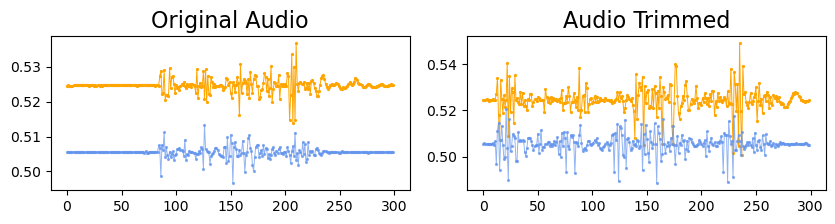

In [69]:
ts1 = X_fearful_scaled[2]
ts1_trimm = X_fearful_trimm_scaled[2]
ts2 = X_fearful_scaled[3]
ts2_trimm = X_fearful_trimm_scaled[3]

#approximation
n_paa_segments = 300
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts1 = paa.fit_transform(ts1.reshape(1, -1))
ts1_trimm = paa.fit_transform(ts1_trimm.reshape(1, -1))
ts2 = paa.fit_transform(ts2.reshape(1, -1))
ts2_trimm = paa.fit_transform(ts2_trimm.reshape(1, -1))

#offset traslation
#ts1 = ts1 - ts1.mean()
#ts2 = ts2 - ts2.mean()
#ts1_trimm = ts1_trimm - ts1_trimm.mean()
#ts2_trimm = ts2_trimm - ts2_trimm.mean()


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10,2))

ax1.plot(ts1.ravel(), marker='o', linewidth=0.7, markersize=1.3, color="orange")
ax1.plot(ts2.ravel(), marker='o', linewidth=0.7, markersize=1.3, color="cornflowerblue", alpha=0.7)

ax2.plot(ts1_trimm.ravel(), marker='o', linewidth=0.7, markersize=1.3, color="orange")
ax2.plot(ts2_trimm.ravel(), marker='o', linewidth=0.7, markersize=1.3, color="cornflowerblue", alpha=0.7)

ax1.set_title("Original Audio", fontsize=16)
ax2.set_title("Audio Trimmed", fontsize=16)

fig.subplots_adjust(hspace=0.3, wspace=0.16)
plt.show()

# Regularization

#### (offset translation, amplitude scaling, remove linear trend, remove noise...)

#### Carefully choose regularization techniques that can be used to preprocess the data and improve its suitability for various analyzes (motif/discord discovery, clustering and classification) but at the same time avoid information leaks.

    Taking into consideration the experiment conducted for audio collection and the nature of the dataset:
    
        + offset translation: by applying this operation, information on the tone of the voice may be lost 
          (however, can be useful to apply this operation to focus on other characteristics of the audio(?))
        + amplitude scaling:
        + linear trend:
        + noise:

### offset traslation

C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


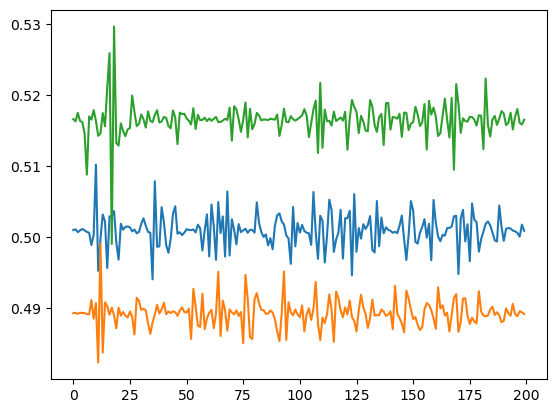

In [152]:
X = X_happy_trimm_scaled
ts1, ts2, ts3 = X[0], X[1], X[2]
n_paa_segments = 200
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)


ts1 = paa.fit_transform(ts1.reshape(1, -1))
ts2 = paa.fit_transform(ts2.reshape(1, -1))
ts3 = paa.fit_transform(ts3.reshape(1, -1))

#offset traslation
#ts1 = ts1 - ts1.mean()
#ts2 = ts2 - ts2.mean()
#ts3 = ts3 - ts3.mean()

plt.plot(ts1.ravel())
plt.plot(ts2.ravel())
plt.plot(ts3.ravel())

# Approximation

### PAA

In [29]:
n_paa_segments = 300

paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

ts_paa = paa.fit_transform(ts.reshape(1, -1))
paa_inv = paa.inverse_transform(ts_paa)

ts_trimmed_paa = paa.fit_transform(ts_trimmed.reshape(1, -1))
paa_inv_trimmed = paa.inverse_transform(ts_trimmed_paa)

C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


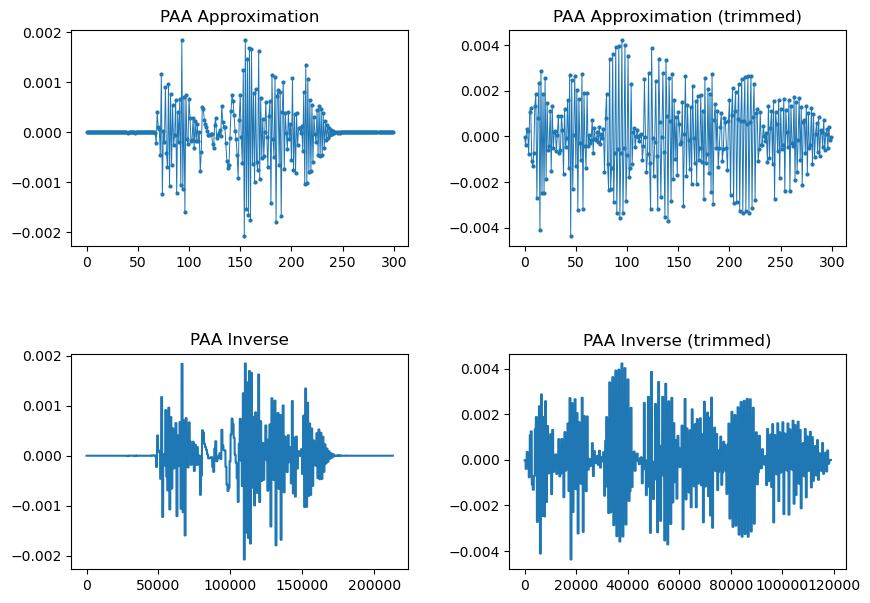

In [30]:
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, sharex=False, figsize=(10,7))

ax1.plot(ts_paa.ravel(), marker='o', linewidth=0.7, markersize=2)
ax2.plot(paa_inv.ravel())

ax3.plot(ts_trimmed_paa.ravel(), marker='o', linewidth=0.7, markersize=2)
ax4.plot(paa_inv_trimmed.ravel())

ax1.set_title("PAA Approximation")
ax2.set_title("PAA Inverse")
ax3.set_title("PAA Approximation (trimmed)")
ax4.set_title("PAA Inverse (trimmed)")

fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [22]:
ts = X_happy_trimm_scaled[0]
ts.shape[0]

140288

### SAX

C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


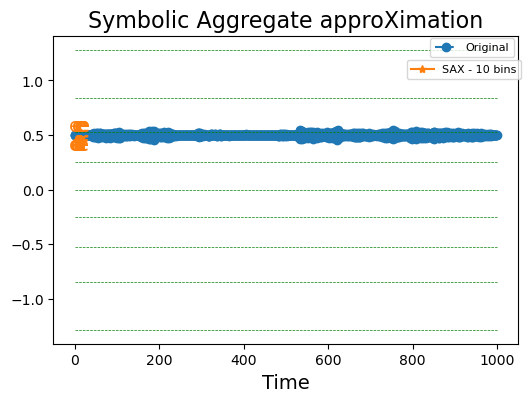

In [53]:
import matplotlib.lines as mlines

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyts.approximation import SymbolicAggregateApproximation
import matplotlib.lines as mlines

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyts.approximation import SymbolicAggregateApproximation
import matplotlib.lines as mlines

ts = X_happy_trimm_scaled[0]#[3400:3420]
#n_timestamps = ts.shape[0]
n_paa_segments = 1000
n_timestamps = n_paa_segments
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts = paa.fit_transform(ts.reshape(1, -1))

# Handling NaN values
nan_indices = np.isnan(ts)
ts = ts[~nan_indices]

# SAX transformation
n_bins = 10

sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='quantile')
ts_sax = sax.fit_transform(ts.reshape(1, -1))

# Compute gaussian bins
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the time series
bottom_bool = np.r_[True, X_sax[0, 1:] > X_sax[0, :-1]]

plt.figure(figsize=(6, 4))
plt.plot(ts, 'o--', label='Original')
for x, y, s, bottom in zip(range(n_timestamps), ts, ts_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, n_timestamps, color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()


C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


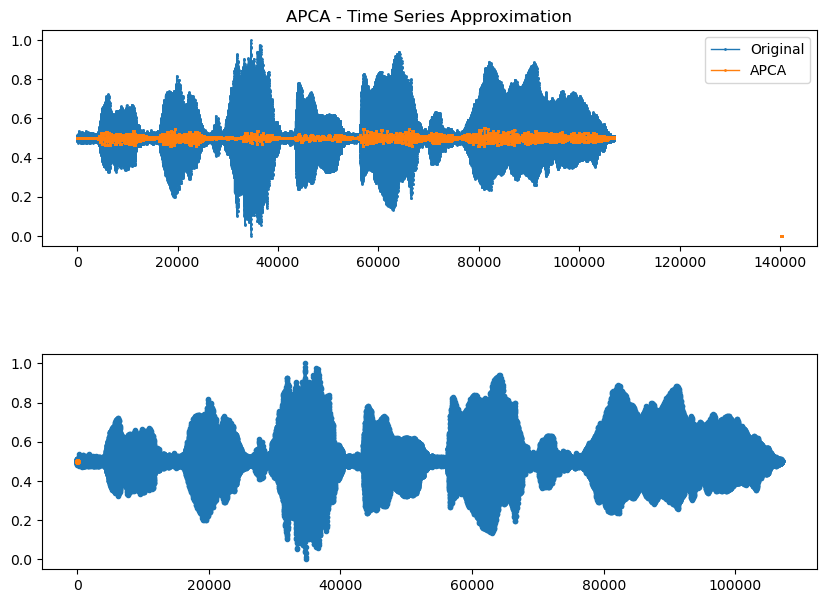

In [131]:
X = X_happy_trimm_scaled[0]#[0:1000]

# Your single time series represented as a numpy array
new_X = X.reshape(-1, 1)
n_timestamps = new_X.shape[0]

#APCA
window_size = 100
n_windows = len(new_X) // window_size
X_apca = np.zeros(len(new_X))

for i in range(n_windows):
    window = new_X[i * window_size: (i + 1) * window_size]
    mean = np.mean(window)
    X_apca[i * window_size: (i + 1) * window_size] = mean
    
#PAA 
n_paa_segments = 100
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(new_X.reshape(1, -1)) 

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(10,7))

ax1.plot(range(n_timestamps), new_X, marker='o', markersize=1, linewidth=1, label='Original')
ax1.plot(range(n_timestamps), X_apca, marker='o', markersize=1, linewidth=1, label='APCA')
ax1.legend(loc='best')
ax1.set_title('APCA - Time Series Approximation')

ax2.plot(new_X, marker='o', markersize=3, linewidth=1.5, label='Original')
ax2.plot(ts_paa.reshape(-1, 1).ravel(), marker='o', linewidth=0.7, markersize=2, label='PAA')


fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()